In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.transform import resize 
import tensorflow as tf
import itertools

## Load Dataset

In [2]:
datamining_dir = "./"

X_train = np.load(datamining_dir + "train_X.npy")
X_test = np.load(datamining_dir + "test_X.npy")
y_train = np.load(datamining_dir + "train_Y.npy")
y_test = np.load(datamining_dir + "test_Y.npy")

X_train_imgs = np.stack((X_train, X_train, X_train), axis=3)
X_test_imgs = np.stack((X_test, X_test, X_test), axis=3)


print("X_train shape ", X_train_imgs.shape)
print("y_train shape ", y_train.shape)
print("X_test shape ", X_test_imgs.shape)
print("y_test shape ", y_test.shape)

X_train shape  (16653, 64, 64, 3)
y_train shape  (16653,)
X_test shape  (4163, 64, 64, 3)
y_test shape  (4163,)


## Display few images

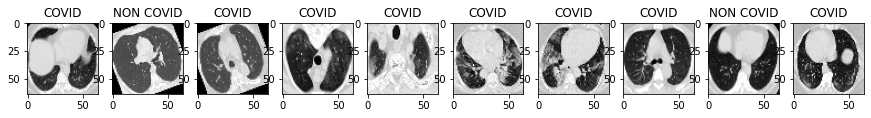

In [3]:
fig, axes = plt.subplots(1,10,figsize=(15,15))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")

## Preparing Model

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
import keras

dims = 64
resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False

## Extending resnet model to train a DNN
dnn = tf.keras.layers.Flatten()(resnet.output)
dnn = tf.keras.layers.Dense(512, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(1, activation='sigmoid')(dnn)

model = Model(resnet.input, dnn)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 27,979,905
Trainable params: 4,392,193
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None


## Training

In [5]:
hist = model.fit(X_train_imgs, y_train, validation_split=0.2, epochs=10, steps_per_epoch = 100)

Epoch 1/10
100/100 [==============================] - 113s 1s/step - loss: 0.7626 - acc: 0.6709 - val_loss: 0.4514 - val_acc: 0.7959
Epoch 2/10
100/100 [==============================] - 102s 1s/step - loss: 0.4280 - acc: 0.8034 - val_loss: 0.3848 - val_acc: 0.8373
Epoch 3/10
100/100 [==============================] - 102s 1s/step - loss: 0.3496 - acc: 0.8475 - val_loss: 0.3838 - val_acc: 0.8259
Epoch 4/10
100/100 [==============================] - 101s 1s/step - loss: 0.2834 - acc: 0.8826 - val_loss: 0.3932 - val_acc: 0.8322
Epoch 5/10
100/100 [==============================] - 101s 1s/step - loss: 0.2381 - acc: 0.9043 - val_loss: 0.3561 - val_acc: 0.8478
Epoch 6/10
100/100 [==============================] - 102s 1s/step - loss: 0.1974 - acc: 0.9229 - val_loss: 0.2892 - val_acc: 0.8847
Epoch 7/10
100/100 [==============================] - 102s 1s/step - loss: 0.1617 - acc: 0.9383 - val_loss: 0.3924 - val_acc: 0.8520
Epoch 8/10
100/100 [==============================] - 108s 1s/step - 

## Evaluating

In [12]:
score, acc = model.evaluate(X_test_imgs, y_test)
y_pred = model.predict(X_test_imgs)
print("Accuracy ", acc*100)

131/131 [==============================] - 26s 198ms/step - loss: 0.3067 - acc: 0.8806
Accuracy  88.06149363517761


## Plotting Loss

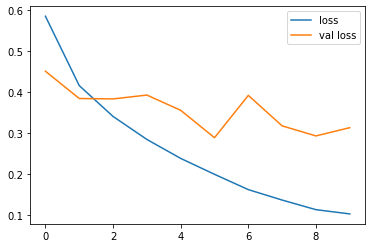

In [7]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()

## Plotting Accuracy

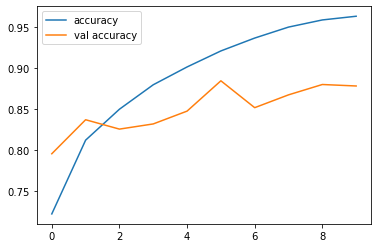

In [8]:
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val accuracy')
plt.legend()

In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Confusion Matrix

Confusion matrix, without normalization
[[1461  377]
 [ 120 2205]]


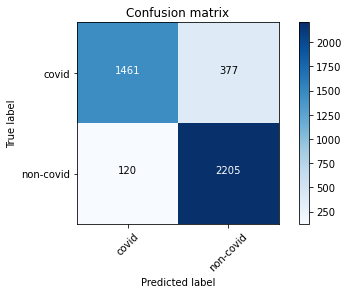

In [26]:
y_pred = np.around(y_pred.reshape(y_test.shape))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['covid', 'non-covid'],
                      title='Confusion matrix')

## Fscore, Precision, Recall

In [27]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
print("Precision of (covid, non-covid): ", precision)
print("Recall of (covid, non-covid): ", recall)
print("Fscore of (covid, non-covid): ", fscore)

Precision of (covid, non-covid):  [0.92409867 0.85398916]
Recall of (covid, non-covid):  [0.79488575 0.9483871 ]
Fscore of (covid, non-covid):  [0.85463586 0.89871612]
